# PROJECT STARTS HERE

# Importing Libraries and Modules

In [2]:
import sklearn
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
# import time
# import mediapipe as mp
# import csv
# import dill
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
# import tensorflow as tf
# tf. __version__

'2.6.0'

In [ ]:
# import pandas as pd
# !pip3 install --upgrade pandas

In [1]:
# !nvidia-smi

In [ ]:
# Installing Libraries

# !pip3 install opencv-python
# !pip3 install dill
# !pip3 install matplotlib
# !pip3 install scikit-learn
# !pip3 install tensorflow

# Frame Extraction

In [ ]:
# Folder path of dataset
folder_path = r'D:\FYP_HWU\Videos'
DATA_PATH = r'D:\FYP_HWU'

In [ ]:
# List of actions to train model with (11 classes or actions)
actions = [
'accident',
'call',
'help',
'man',
'murder',
'woman',
'danger',
'police',
'follow',
'child',
'sick'
]


In [ ]:
temp_actions = ['follow', 'child','police']

In [ ]:
len(temp_actions)

3

### Counting number of videos under each action in the dataset

In [ ]:
# folder_path = r'C:\Users\dr2007\Documents\FYP_HWU\Aug_Frames'
folder_path = r'D:\WLASL Datasets\Kaggle_WLASL_withVideosInClassFolders\dataset\SL'

In [ ]:
# Initializing variables
video_count = {}
folder_path = r'D:\FYP_HWU\NEW_Frames'

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        if (i in actions): #if the keyword is present in the shortlisted list of actions
            for root, dirs, files in os.walk(os.path.join(folder_path, i)):
                video_count[i] = len(dirs)
                break
    break

print(video_count)

{'accident': 13, 'call': 12, 'child': 9, 'danger': 11, 'follow': 9, 'help': 14, 'man': 12, 'murder': 13, 'police': 10, 'sick': 10, 'woman': 11}


In [ ]:
# Initializing variables
video_count = {}
first_11_items = {}

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        for root, dirs, files in os.walk(os.path.join(folder_path, i)):
            video_count[i] = len(files)
            break

    break


In [ ]:
video_count1 = sorted(video_count.items(), key=lambda x:x[1], reverse = True)

In [ ]:
for idx, k in enumerate(video_count1):
    if idx == 11: break
    first_11_items[k[0]] = k[1]

print(first_11_items)
# print(video_count)

{'cousin': 17, 'before': 16, 'cool': 16, 'thin': 16, 'drink': 15, 'go': 15, 'computer': 14, 'help': 14, 'inform': 14, 'take': 14, 'who': 14}


In [ ]:
# print(video_count1)

In [ ]:
# video_count = {'accident': 13, 'call': 12, 'child': 9, 'danger': 11, 'help': 14, 'man': 12, 'murder': 13, 'police': 10, 'sick': 10, 'woman': 11}

In [ ]:
temp_video_count = {'follow': 36, 'child': 36, 'police': 40}

In [ ]:
len(temp_video_count)

3

### Getting the video paths of the videos

In [ ]:
video_paths = {}

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):

    for action in actions:
        for root, dirs, files in os.walk(os.path.join(folder_path, action)):
            for i in range (len(files)):
                files[i] = os.path.join(folder_path, action, files[i])
            video_paths[action] = files
            break
    break

# print(video_paths)

In [ ]:
# converting the folderpaths to csv file
df = pd.DataFrame.from_dict(video_paths, orient='index')
df = df.transpose()
df.to_csv('video_paths.csv', index=False)

In [ ]:
# Reading a csv file to get the video paths
def read_csv_to_dict(csv_file):
    result_dict = {}

    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)

        # Read the header row to get the keys
        keys = next(csv_reader, None)
        if keys:
            for key in keys:
                result_dict[key] = []

            # Read the rest of the rows and store values in the dictionary
            for row in csv_reader:
                for i in range(len(keys)):
                    result_dict[keys[i]].append(row[i])

    return result_dict

In [ ]:
video_paths = read_csv_to_dict("video_paths.csv")

In [ ]:
print(temp_video_path)

In [ ]:
# print(video_paths)

### Creating folders to store frames

In [ ]:
#Creating folder 'Frames' that will contain all the video frames
# os.makedirs(os.makedirs(os.path.join(DATA_PATH,'Frames')))
# os.makedirs(os.path.join(DATA_PATH,'Original_Frames'))

In [ ]:
#Creating folder 'NEW_Frames' that will contain all the video frames
DATA_PATH = r'D:\FYP_HWU'
os.makedirs(os.path.join(DATA_PATH,'NEW_Frames'))

In [ ]:
#Creating one folder for each action
for action in video_paths.keys():
    # 1 folder for each video of the action
    for sequence in range(len(video_paths[action])):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Extracting frames from videos and adding them to folders

### APPROACH 1
Here, a fixed number of frames are extracted from each video (60 in the current case). If the extracted frames from a video are less than 60, then the last frame is repeated to reach the 60 count. If the video is too long, then then the first 60 frames of the video will be extracted.

In [ ]:
#looping through each action
for action in video_paths.keys():

    #Looping through each video of the action
    for sequence in range(len(video_paths[action])):

        # Open the video file
        cap = cv2.VideoCapture(video_paths[action][sequence])

        # Initializing variables
        frame_count = 0       # current frame count
        max_fc = 60          # maximum frame count


        #while the video is accessible and the current frame count doesn't exceed the max frame count limit
        while (cap.isOpened() and frame_count < max_fc):
            #reading the video frame
            success, frame = cap.read()

            #if there are frames
            if success:
                image = frame.copy()
                cv2.imshow("{} - {}".format(action, sequence), image)

                #saving the extracted frames (in jpg format)
                cv2.imwrite(os.path.join(DATA_PATH , action, str(sequence), 'frame'+ str(frame_count) + '.jpg'), image)
                frame_count+=1
            else:
                break

        # repeat last frame until we reach max frame count
        while frame_count < max_fc:
            cv2.imwrite(os.path.join(DATA_PATH , action, str(sequence), 'frame'+ str(frame_count) + '.jpg'), image)
            frame_count+=1

        cap.release()
        cv2.destroyAllWindows()

### APPROACH 2
Here too, a fixed number of frames are extracted from each video (20 in the current case). The frames will be extracted after dividing the complete video into equal parts and then choosing the frames from each part. This way we will be able to avoid the first few or last frames few of the video if no action is being depicted. Secondly, the basic movement of the action is captured.

In [ ]:
# how many frames to extract?
count = []
for action in video_paths.keys():
        #Looping through each video of the action
        for sequence in range(len(video_paths[action])):
            cap = cv2.VideoCapture(video_paths[action][sequence])
            total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            count.append(total_frames)
            cap.release()

In [ ]:
print(min(count))

25.0


In [ ]:
print(max(count))

155.0


In [ ]:
# tcount = []
# cap = cv2.VideoCapture(video_paths['accident'][0])
# total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# tcount.append(total_frames)
# cap.release()

In [ ]:
# print(tcount)

In [ ]:
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

In [ ]:
def frameSkipping(video_paths, n):
    for action in video_paths.keys():

        #Looping through each video of the action
        for sequence in range(len(video_paths[action])): #len(video_paths[action])
            cap = cv2.VideoCapture(video_paths[action][sequence])

            total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)  #getting the total frame count
            frames_step = total_frames//n    # getting the number of frames to skip

            for frame_num in range(n):
                #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
                cap.set(1,frame_num*frames_step)
                success,image = cap.read()
                #save your image
                cv2.imwrite(os.path.join(DATA_PATH, action, str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)

            cap.release()


In [ ]:
frameSkipping(video_paths, 20)

# Data Preprocessing

By the end of this section, we will folders containing the images frames stored in jpg format for each video of each action.

## Data Augmentation
 Using:
 - Frame Mirroring (Flipping the image horizontally)
 - Changing contrast, brightness and saturation levels
 - Rotating

 Here, we take each video, extract frames and for each frame, apply the filters (which may wither include changing the contrast and brightness of the image frame, mirroring the image or extracting only the keypoints and the edges from the image), and store them as a separate video.


In [ ]:
def blackAndWhite(image): # takes image as a parameter
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(0)

    # return np.array(new_image)
    return new_image

In [ ]:
def saturation(image): # takes image as a parameter
    # Horizontally flipping the image
    image = flipImage(image)
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(1.5)

    # return np.array(new_image)
    return new_image

In [ ]:
def flipImage(image): # takes image as a parameter
    # Converting Image to numpy array
    new_image = np.array(image)

    # Horizontally flipping the image
    image = cv2.flip(new_image, 1)

    # Converting numpy aray to image format
    image = Image.fromarray(image.astype('uint8'))

    # Returning the image in image format
    return image

In [ ]:
def rotateImage(image):
    image  = image.rotate(-8)  #- or + -> left or right
    return image

In [ ]:
# Cropping the center of the image (cropping out the extra background margins of the video.)
def crop_center_square(frame): # takes image as a parameter
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [ ]:
# Function to resize the frames
def resizeFrames(new_image, resize): # takes numpy array as parameter
    new_image = crop_center_square(new_image)
    new_image = cv2.resize(new_image, resize)
    return new_image # returns a numpy array

In [ ]:
# Getting the final number of videos under each Action
def totalVideoCount(DATA_PATH):
    finalVideoCount = {}
    for root, dirs, files in os.walk(DATA_PATH):
        for folder in dirs:
            for root, dirs, files in os.walk(os.path.join(DATA_PATH, folder)):
                finalVideoCount[folder] = len(dirs)
                break
    return finalVideoCount

In [ ]:
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'
VideoCount = totalVideoCount(DATA_PATH)
print(VideoCount)

{'accident': 13, 'call': 12, 'child': 9, 'danger': 11, 'follow': 9, 'help': 14, 'man': 12, 'murder': 13, 'police': 10, 'sick': 10, 'woman': 11}


In [ ]:
# max_fc = 20 (maximum number of frames extracted per video), variable already initialized earlier

# loop through each video (sequence) for each action
# create another sequece folder (my_dict[action] + count), where count is incremented with every sequence loop iteration
# for loop for i in range(20):
# get the image -> concat('frame', str(i))
# apply filters
# save the image in the new folder created

max_fc = 20
resize = (224,224)
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames'
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

finalVideoCount = totalVideoCount(AUG_PATH)
video_count = totalVideoCount(DATA_PATH)

#looping through each action
for action in video_count.keys():
    actionCount = finalVideoCount[action]

    #Looping through the count for videos for that action
    for sequence in range(video_count[action]):

        #creating a folder to store the augmented images
        folder_number = actionCount + sequence
        if(folder_number < 45):
            try:
                os.makedirs(os.path.join(AUG_PATH, action, str(folder_number)))
            except:
                pass

            for frame_num in range (max_fc):
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                # Resizing the Image
#                 new_image = resizeFrames(image, resize)

                #Converting numpy array to Image
                image = Image.fromarray(image.astype('uint8'))

                # Applying the filters
#                 new_image = blackAndWhite(image)
#                 new_image = flipImage(image)
#                 new_image = saturation(image)
                new_image = rotateImage(image)

                # Converting Image to numpy array
                new_image = np.array(new_image)

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(AUG_PATH , str(action), str(folder_number), 'frame'+ str(frame_num) + '.jpg'), new_image)

                # Displaying Image
                cv2.destroyAllWindows()

        else:
            break


In [ ]:
finalVideoCount = totalVideoCount(AUG_PATH)
print(finalVideoCount)

{'accident': 45, 'call': 45, 'child': 45, 'danger': 45, 'follow': 45, 'help': 45, 'man': 45, 'murder': 45, 'police': 45, 'sick': 45, 'woman': 45}


## Resizing Images

Resizing the images to 224 x 224 pixel size to feed to ResNet 50 pre trained model.

In [ ]:
# Cropping the center of the image (cropping out the extra background margins of the video.)
def crop_center_square(frame): # takes image as a parameter
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [ ]:
# Function to resize the frames
def resizeFrames(new_image, resize): # takes numpy array as parameter
    new_image = crop_center_square(new_image)
    new_image = cv2.resize(new_image, resize)
    return new_image # returns a numpy array

In [ ]:
max_fc = 20
resize = (224,224)
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames'
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

videoCount = totalVideoCount(DATA_PATH) #getting a video count from original frame dataset

#looping through each action
for action in videoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(videoCount[action]):

        #creating a folder in AUG frames folder
        try:
            os.makedirs(os.path.join(AUG_PATH, action, str(sequence)))
        except:
            pass

        # iterating through each frame in the original frame dataset
        for frame_num in range (max_fc):
            IMAGE_PATH = os.path.join(DATA_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

            # Reading the image
            image = cv2.imread(IMAGE_PATH)

            new_image = resizeFrames(image, resize)

            #Saving the image in the folder created
            cv2.imwrite(os.path.join(AUG_PATH, str(action), str(sequence), 'frame' + str(frame_num) + '.jpg'), new_image)

            # Displaying Image
            cv2.destroyAllWindows()


## Keypoint Extraction using MediaPipe Holistics
Applying MediaPipe Keypoint Landmarks to the extracted frames

In [ ]:
mp_holistic = mp.solutions.holistic #Holistic model (use for detections)
mp_drawing = mp.solutions.drawing_utils #Drawing Utilities
drawing_spec = mp_drawing.DrawingSpec(thickness = 1, circle_radius=1)

In [ ]:
#Capturing landmarks
def mediapipeHolistics(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion -> BGR to RGB
    image.flags.writeable = False
    results = model.process(image) # Making Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion -> RGB to BGR
    return image, results

In [ ]:
#Visualize landmarks, connecting the landmarks on the image (drawing only pose and had landmarks)
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.pose_landmarks,
                              connections = mp_holistic.POSE_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.left_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.right_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)

In [ ]:
max_fc = 20
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames'
FRAMES_PATH = r'D:\FYP_HWU\NEW_MP_Frames'

finalVideoCount = totalVideoCount(AUG_PATH)

#looping through each action
for action in finalVideoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(finalVideoCount[action]):

        # Creating folders to store frames and extracted landmarks
        try:
            os.makedirs(os.path.join(FRAMES_PATH, action, str(sequence)))
        except:
            pass

        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
            for frame_num in range (max_fc):

                # Getting the extracted frame from the folder
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                # Making detection
                image, result = mediapipeHolistics(image, holistic)

                #Darwing landmarks on frames
                draw_landmarks(image,result)

#                 image = Image.fromarray(image.astype('uint8'))

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(FRAMES_PATH , str(action), str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)

                # Displaying Image
                cv2.destroyAllWindows()


# Creating the Dataset

### Visualizing dataset frames

In [3]:
from PIL import Image, ImageEnhance
from IPython.display import Image
DATA_PATH = r'NEW_MP_Frames'

ACTION: Man    Video: 0     Frame: 22


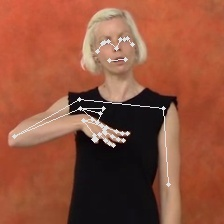

In [ ]:
# man (video 0, frame 22)
print("ACTION: Man    Video: 0     Frame: 22")
display(Image(filename="{}/man/0/frame15.jpg". format(DATA_PATH)))

## Creating Labels and Features

In [4]:
# !pip3 install tensorflow --user

In [ ]:
# !pip3 uninstall numpy==1.26.0
# !pip3 install numpy==1.23.5 --user
# import tensorflow as tf

In [1]:
# import numpy as np 
# np.__version__  #'1.23.5'

'1.23.5'

In [ ]:
# !pip3 install --upgrade "protobuf<=3.20.1"

In [20]:
# import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Splitting data in 80:10:10 train:validation:test ratio
def trainTestSplit(X,y):
    x_train, x_temp, y_train, y_temp= train_test_split(X, y, test_size=0.2, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
# def trainTestSplit(X,y):
#     x_train, x_val, y_train, y_val= train_test_split(X, y, test_size=0.1, random_state=42)
#     return x_train, y_train, x_val, y_val

In [3]:
# DATA_PATH = r'NEW_MP_Frames'
DATA_PATH = r'C:\Users\revan\Documents\FYP_HWU\NEW_MP_Frames'
# DATA_PATH = r'C:\Users\dr2007\Documents\FYP_DATA\NEW_MP_Frames'

In [4]:
# Getting the final number of videos under each Action
def totalVideoCount(DATA_PATH):
    finalVideoCount = {}
    for root, dirs, files in os.walk(DATA_PATH):
        for folder in dirs:
            for root, dirs, files in os.walk(os.path.join(DATA_PATH, folder)):
                finalVideoCount[folder] = len(dirs)
                break
    return finalVideoCount

In [5]:
# Creating subset to to test whether the model works fine
total_video_count = totalVideoCount(DATA_PATH)
temp_list = ['police', 'follow', 'child', 'woman', 'man', 'help', 'call', 'danger', 'murder', 'accident']
subset_video_count = {}
for temp in temp_list:
    subset_video_count[temp] = total_video_count[temp]

print(subset_video_count)

{'police': 45, 'follow': 45, 'child': 45, 'woman': 45, 'man': 45, 'help': 45, 'call': 45, 'danger': 45, 'murder': 45, 'accident': 45}


In [6]:
# Setting numeric labels for non numeric action category values
label_map = {label:num for num, label in enumerate(subset_video_count.keys())} #subset of classes

In [6]:
print(label_map)

{'police': 0, 'follow': 1, 'child': 2, 'woman': 3, 'man': 4, 'help': 5, 'call': 6, 'danger': 7, 'murder': 8, 'accident': 9}


### Preparing Data with Extracted Frames

In [7]:
def frameEnhance(frame):
    # Converting BGR -> RGB
    frame = frame[:, :, [2, 1, 0]]
    # Normalize the pixel values
    frame = frame / 255.0
    return frame

#### For ALL classes

In [8]:
# For ALL the classes
max_fc = 20
videoFrames=[]
videolabels=[]

# Iterating through each action
for action in total_video_count.keys():

    # Iterting through each video in the action
    for sequence in range(total_video_count[action]):

        # Declaring a list to store the frames of each video
        frames = []

        # Iterating through each frame
        for frame_num in range(max_fc):

            # Loading the image frame
            frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
            frame = frameEnhance(frame)

            # Appending to the list
            frames.append(frame)

        # Adding to the dataset
        videoFrames.append(frames)
        videolabels.append(label_map[action])

    print("Action {} done".format(action))
cv2.destroyAllWindows()

Action accident done
Action call done
Action child done
Action danger done
Action follow done
Action help done
Action man done
Action murder done
Action police done
Action sick done
Action woman done


In [ ]:
# # For all classes
# max_fc = 20
# videoFrames=[]
# videolabels=[]

# # Iterating through each action
# for action in total_video_count.keys():

#     # Iterting through each video in the action
#     for sequence in range(total_video_count[action]):

#         # Iterating through each frame
#         for frame_num in range(max_fc):

#             # Loading the image frame
#             frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
#             frame = frameEnhance(frame)

#             # Appending to the list
#             videoFrames.append(frame)

#         # Adding to the dataset
#         videolabels.append(label_map[action])

#     print("Action {} done".format(action))
# cv2.destroyAllWindows()

In [9]:
# print(total_video_count)
print(DATA_PATH)

C:\Users\revan\Documents\FYP_HWU\NEW_MP_Frames


#### For subset (10 classes)

In [8]:
# For subset of the classes (3 classes) [child, follow, police, woman]
max_fc = 20
videoFrames=[]
videolabels=[]

# Iterating through each action
for action in subset_video_count.keys():

    # Iterting through each video in the action
    for sequence in range(subset_video_count[action]):

        # Declaring a list to store the frames of each video
        frames = []

        # Iterating through each frame
        for frame_num in range(max_fc):

            # Loading the image frame
            frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
            frame = frameEnhance(frame)

            # Appending to the list
            frames.append(frame)

        # Adding to the dataset
        videoFrames.append(frames)
        videolabels.append(label_map[action])

    print("Action {} done".format(action))
cv2.destroyAllWindows()

Action police done
Action follow done
Action child done
Action woman done
Action man done
Action help done
Action call done
Action danger done
Action murder done
Action accident done


In [8]:
max_fc = 20
videoFrames=[]
videolabels=[]

# Iterating through each action
for action in subset_video_count.keys():

    # Iterting through each video in the action
    for sequence in range(subset_video_count[action]):

        # Iterating through each frame
        for frame_num in range(max_fc):

            # Loading the image frame
            frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
            frame = frameEnhance(frame)

            # Appending to the list
            videoFrames.append(frame)

        # Adding to the dataset
        videolabels.append(label_map[action])

    print("Action {} done".format(action))
cv2.destroyAllWindows()

Action police done
Action follow done
Action child done
Action woman done
Action man done
Action help done
Action call done
Action danger done
Action murder done
Action accident done


In [9]:
X = np.array(videoFrames)

In [32]:
X.shape

(450, 20, 224, 224, 3)

In [10]:
# np.array(videolabels).shape
# The below code will convert the target class to this format: [1,0,0], [0,1,0], [0,0,1]
y_labels = to_categorical(videolabels).astype(int)

In [31]:
y_labels.shape 

(450, 10)

In [16]:
# print(y_labels)

In [172]:
# Splitting into Train, Validation and Test
# X_train, y_train, X_val, y_val = trainTestSplit(X, y)
# X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X_total, y)

In [167]:
# X_total.shape

(360, 20, 2048)

In [18]:
# y.shape

In [14]:
# X.shape

(450, 20, 224, 224, 3)

In [107]:
# X_test.shape

(36, 20, 2048)

In [90]:
# y_train.shape

(162, 4)

In [29]:
# X_val.shape

(36, 20, 224, 224, 3)

# Building the model

In [15]:
# tensorflow
# import tensorflow.keras as keras
# import tensorflow as tf

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

## Training the model

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [17]:
log_dir = r'C:\Users\revan\Documents\FYP_HWU\Logs'
# os.makedirs('Logs')

In [58]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Xception_10C_2.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True)

In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, LSTM, Bidirectional, Input, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, Concatenate, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from keras.callbacks import LearningRateScheduler
# from keras.optimizers import Adam, RMSprop, SVM
from tensorflow.keras.optimizers import Adam, RMSprop

In [35]:
batch_size = 2
epochs = 10

In [174]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

### ResNet50 + BiLSTM Model

In [11]:
# from tensorflow.keras.models import load_model
log_dir = r'C:\Users\revan\Documents\FYP_HWU\Logs'
folder_path = os.path.join(log_dir,"ckpt.Xcep_Bi_10C_3.keras")
res50LoadModel=load_model(folder_path)

In [12]:
res50LoadModel.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 20, 64)            532736    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0   

#### Feature Extraction using ResNet + BiLSTM model - METHOD 3

In [27]:
from tensorflow.keras.models import load_model
log_dir = r'C:\Users\revan\Documents\FYP_HWU\Logs'
# folder_path = os.path.join(log_dir,"ckpt.Res50_sub1.keras")
folder_path = os.path.join(log_dir,"ckpt.ResNet_sub_8C_2.keras")
res50LoadModel=load_model(folder_path)

In [28]:
res50LoadModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 7, 7, 2048)    23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2048)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 327688    
Total params: 23,915,400
Trainable params: 327,688
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
def fe_PretrainedM(df, pretrained_model):
    feature_extraction_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-3].output)  
    fe_video = []

    for video in df:
        video = np.expand_dims(video, axis=0)
        features = feature_extraction_model.predict(video, verbose=1)
        fe_video.append(features)

    return fe_video



In [34]:
X_test.shape

(36, 20, 224, 224, 3)

In [32]:
# Example usage:
extracted_features = fe_PretrainedM(x, res50LoadModel)

1/1 [==============================] - 0s 21ms/step


In [84]:
features.shape

(171, 20, 2048)

In [33]:
arr = np.array(extracted_features)
X_train = np.squeeze(arr, axis=1)
print(X_train.shape)

(288, 20, 2048)


In [35]:
# fe_Xtrain = fe_PretrainedM(X_train.tolist(), res50Model)
fe_Xtest =  fe_PretrainedM(X_test, res50LoadModel)
arr = np.array(fe_Xtest)
X_test = np.squeeze(arr, axis=1)
print(X_test.shape)

1/1 [==============================] - 0s 23ms/step
(36, 20, 2048)


In [36]:
# X_train.shape
X_val.shape

(36, 20, 224, 224, 3)

In [37]:
# fe_Xtrain = fe_PretrainedM(X_train.tolist(), res50Model)
fe_Xval =  fe_PretrainedM(X_val, res50LoadModel)
arr = np.array(fe_Xval)
X_val = np.squeeze(arr, axis=1)
print(X_val.shape)

1/1 [==============================] - 0s 18ms/step
(36, 20, 2048)


In [47]:
X_val.shape

(9, 20, 224, 224, 3)

#### Modifying data structure to pass to BiLSTM model
Each video consisiting of 20 frame -> 20 records each representing 1 frame
So the shape will change from (171,20,224,224,3) -> (513,224,224,3)
Make the batch size as 20 for training BiLSTM model

In [ ]:
# loading pretrained ResNet model
from tensorflow.keras.models import load_model

log_dir = r'C:\Users\dr2007\Documents\FYP_DATA\Logs'
folder_path = os.path.join(log_dir,"ckpt.Res50_sub1.keras")
res50Model=load_model(folder_path)

In [ ]:
res50Model.summary()
# check which layer gives (20,2048) use that layer during feature extraction

In [ ]:
def fe_PretrainedM(df, pretrained_model):
    feature_extraction_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[-4].output)
    fe_video = []
    for video in df:
        video = np.expand_dims(video, axis=0)
        features = feature_extraction_model.predict(video, verbose=1)
        fe_video.append(features)
    return fe_video

In [ ]:
# Example usage:
extracted_features = fe_PretrainedM(X_train, res50LoadModel)

In [ ]:
arr = np.array(extracted_features)
features = np.squeeze(arr, axis=1)
features.shape

In [ ]:
# fe_Xtrain = fe_PretrainedM(X_train.tolist(), res50Model)
fe_Xval =  fe_PretrainedM(X_val, res50LoadModel)
arr = np.array(fe_Xval)
fe_Xval = np.squeeze(arr, axis=1)

In [65]:
new_Xtrain = []
new_yTrain = []
video_count = 0

for video in features: #iterating through 171 video
    frame_class = y_train[video_count]
    for frame in video: #iterating through 20 frames
        new_Xtrain.append(frame)
        new_yTrain.append(frame_class)
    video_count+=1



In [66]:
new_Xtrain = np.array(new_Xtrain)
new_yTrain = np.array(new_yTrain)
print(new_Xtrain.shape)
print(new_yTrain.shape)


(3420, 2048)
(3420, 4)


In [70]:
# DO THE SAME FOR X VAL DATASET
new_Xval = []
new_yVal = []
video_count = 0

for video in fe_Xval: #iterating through 171 video
    frame_class = y_val[video_count]
    for frame in video: #iterating through 20 frames
        new_Xval.append(frame)
        new_yVal.append(frame_class)
    video_count+=1

In [71]:
new_Xval = np.array(new_Xval)
new_yVal = np.array(new_yVal)
print(new_Xval.shape)
print(new_yVal.shape)

(180, 2048)
(180, 4)


In [85]:
# Updated BiLSTM CODE
# Input layer for the video frames
input_frames = Input(shape=(20, 2048))

# Bidirectional LSTM layer
bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
bilstm_output = Bidirectional(LSTM(128, return_sequences=False))(bilstm_output)

# Global Average Pooling layer to reduce temporal dimensions
# global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(bilstm_output)

# Fully connected layers for video-level classification
# dense_layer = (Flatten())(bilstm_output)
dense_layer = Dense(64, activation='relu')(bilstm_output)
# dense_layer = BatchNormalization() (dense_layer)
dense_layer = Dense(128, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)
# # dense_layer = BatchNormalization()(dense_layer)
# # dense_layer = Dense(256, activation='relu')(dense_layer)
# # dense_layer = Dropout(0.5)(dense_layer)
# dense_layer = BatchNormalization()(dense_layer)
# dense_layer = Dense(64, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)

output_layer = Dense(4, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model2 = Model(inputs=input_frames, outputs=output_layer)



In [86]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [87]:
hybrid_model2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 20, 128)           1081856   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 516       
Total params: 1,370,308
Trainable params: 1,370,308
Non-trainable params: 0
_________________________________________________

In [72]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x_t = tf.convert_to_tensor(new_Xtrain, np.float32)
   y_t = tf.convert_to_tensor(new_yTrain, np.float32)
   x_te = tf.convert_to_tensor(new_Xval, np.float32)
   y_te = tf.convert_to_tensor(new_yVal, np.float32)

In [ ]:
history1_2_1 = hybrid_model2.fit(x_t, y_t, epochs=7, batch_size=20, validation_data=(x_te, y_te))

#### BiLSTMs (Alone)

In [36]:
from keras.regularizers import l2
from keras.layers import Dropout

input_frames = Input(shape=(20, 2048))

# Bidirectional LSTM layer
bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
bilstm_output = Bidirectional(LSTM(128, return_sequences=True))(bilstm_output)
bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# Fully connected layers for video-level classification
dense_layer = Dense(64, activation='relu')(bilstm_output)
# dense_layer = Dropout(0.5)(dense_layer)  # Adding dropout
dense_layer = Dense(64, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)  # Adding dropout
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)  # Adding L2 regularization
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)  # Adding L2 regularization
output_layer = Dense(10, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model = Model(inputs=input_frames, outputs=output_layer)


In [103]:
# input_frames = Input(shape=(20, 2048))

# bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# # bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# dense_layer = Dense(32, activation='relu')(bilstm_output)
# # dense_layer = BatchNormalization()(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)
# dense_layer = Dense(16, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)

# output_layer = Dense(10, activation='softmax')(dense_layer)

# hybrid_model2_2 = Model(inputs=input_frames, outputs=output_layer)

In [134]:
from tensorflow.keras.regularizers import l2

In [68]:
# # Define the regularization strength
# l2_reg = 0.001  # You can adjust this value as needed

# input_frames = Input(shape=(20, 2048))

# bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# # Add L2 regularization to the dense layers
# dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(bilstm_output)
# dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)

# output_layer = Dense(10, activation='softmax')(dense_layer)

# hybrid_model2_1 = Model(inputs=input_frames, outputs=output_layer)

In [37]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
hybrid_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           1081856   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128  

In [18]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Res50_Bi_10C_2.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True)

In [38]:
history2_1 = hybrid_model.fit(x, y, epochs=20, batch_size=16, validation_data=(X_val1, y_val1), callbacks = [checkpoint,earlyStopping])

Epoch 1/20
23/23 [==============================] - 5s 68ms/step - loss: 2.4045 - accuracy: 0.1083 - val_loss: 2.4019 - val_accuracy: 0.0444
Epoch 2/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3903 - accuracy: 0.1417 - val_loss: 2.3936 - val_accuracy: 0.0667
Epoch 3/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3748 - accuracy: 0.1083 - val_loss: 2.3672 - val_accuracy: 0.0667
Epoch 4/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3615 - accuracy: 0.1083 - val_loss: 2.3684 - val_accuracy: 0.0444
Epoch 5/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3531 - accuracy: 0.1139 - val_loss: 2.3567 - val_accuracy: 0.0444
Epoch 6/20
23/23 [==============================] - 0s 15ms/step - loss: 2.3473 - accuracy: 0.1139 - val_loss: 2.3537 - val_accuracy: 0.0444
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3418 - accuracy: 0.0889 - val_loss: 2.3512 - val_accuracy: 0.0667
Epoch 8/20
23

In [34]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train1, np.float32)
   y = tf.convert_to_tensor(y_train1, np.float32)


In [92]:
fe_Xval.shape

(9, 20, 2048)

In [71]:
y.shape

(40, 8)

#### ResNet50 Model (Alone)

In [22]:
import tensorflow as tf

In [55]:
# Load pre-trained ResNet50 without the top (fully connected) layers
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

# Apply TimeDistributed to the ResNet50 base
resnet_output = TimeDistributed(resnet_model)(input_frames)

# Global Average Pooling layer to reduce spatial dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(resnet_output)

# Fully connected layers for video-level classification
dense_layer = (Flatten())(global_avg_pool)
# dense_layer = Dropout(0.2)(dense_layer)
# dense_layer = Dense(64, activation='relu')(dense_layer)
# dense_layer = Dense(128, activation='relu')(dense_layer)
# dense_layer = Dense(64, activation='relu')(dense_layer)
output_layer = Dense(10, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model2 = tf.keras.models.Model(inputs=input_frames, outputs=output_layer)


In [83]:
hybrid_model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 7, 7, 2048)    23587712  
_________________________________________________________________
time_distributed_11 (TimeDis (None, 20, 2048)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                409610    
Total params: 23,997,322
Trainable params: 409,610
Non-trainable params: 23,587,712
_________________________________________________________________


In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X, y_labels)

In [56]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)
   # x_val = tf.convert_to_tensor(X_val, np.float32)
   # y_val = tf.convert_to_tensor(y_val, np.float32)

In [36]:
y_train.shape

(360, 10)

In [68]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Res50_10C_4.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min', restore_best_weights=True)

In [69]:
history = hybrid_model2.fit(x, y, epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/50
23/23 [==============================] - 17s 737ms/step - loss: 0.4799 - accuracy: 0.9417 - val_loss: 0.7778 - val_accuracy: 0.8000
Epoch 2/50


c:\Users\revan\anaconda3\envs\test_env_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


23/23 [==============================] - 16s 710ms/step - loss: 0.4458 - accuracy: 0.9500 - val_loss: 0.8603 - val_accuracy: 0.7333
Epoch 3/50
23/23 [==============================] - 16s 711ms/step - loss: 0.4594 - accuracy: 0.9556 - val_loss: 0.7765 - val_accuracy: 0.8222
Epoch 4/50
23/23 [==============================] - 16s 716ms/step - loss: 0.4549 - accuracy: 0.9611 - val_loss: 0.8315 - val_accuracy: 0.8889
Epoch 5/50
23/23 [==============================] - 17s 748ms/step - loss: 0.4475 - accuracy: 0.9583 - val_loss: 0.7849 - val_accuracy: 0.8000
Epoch 6/50
23/23 [==============================] - 16s 712ms/step - loss: 0.4430 - accuracy: 0.9639 - val_loss: 0.8137 - val_accuracy: 0.8444
Epoch 7/50
23/23 [==============================] - 16s 712ms/step - loss: 0.4381 - accuracy: 0.9611 - val_loss: 0.7892 - val_accuracy: 0.8000
Epoch 8/50
23/23 [==============================] - 16s 710ms/step - loss: 0.4428 - accuracy: 0.9583 - val_loss: 0.7648 - val_accuracy: 0.8000
Epoch 9/50

#### ResNet to train on Frames (to be passed to BiLSTM)

Steps:
1) the dataset that we have currently has each record as frames of a video.
2) each record (only of X dataset, not y) is passed through the ResNet 50  model, and the features are extracted (2048 columns) and stored in a list.
3) this list is then converted and stored as a csv file. (7200 rows and 2048 cols)
4) the csv file is then read, and every 20 frame records are clumped to form a video.
5) so, the final dataset is of the shape (360, 20, 2048).
6) this dataset undergoes train val test split.
7) these datasets are feeded to the BiLSTM model.

In [10]:
def fe_PretrainedM(df, pretrained_model):
    fe_video = []
    count = 1
    for frame in df:
            features = extract_features(frame, pretrained_model)
            fe_video.append(features) 
            print(count)
            count+=1
            
    # return fe_video, new_y
    return fe_video


In [11]:
def extract_features(frame, model):
    img = np.expand_dims(frame, axis=0)  # Add batch dimension
    features = model.predict(img, verbose = 1)  # Extract features
    return features.flatten()  # Flatten the features

In [14]:
fe_video = fe_PretrainedM(X, hybrid_model)
features_df = pd.DataFrame(fe_video)
# features_y = pd.DataFrame(y)

# Save the DataFrame to a CSV file
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_features.csv'
features_df.to_csv(fe_csv, index=False)

1/1 [==============================] - 7s 7s/step
1
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 19ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 17ms/step
9
1/1 [==============================] - 0s 26ms/step
10
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 25ms/step
12
1/1 [==============================] - 0s 29ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 21ms/step
15
1/1 [==============================] - 0s 18ms/step
16
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [================

In [17]:
labels_df = pd.DataFrame(y_labels)
# features_y = pd.DataFrame(y)

# Save the DataFrame to a CSV file
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'
labels_df.to_csv(lb_csv, index=False)

In [30]:
# Reading the csv files
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_features.csv'
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'
X = pd.read_csv(fe_csv)
X_arr1 = X.to_numpy()

# y_labels = pd.read_csv(lb_csv)
# y_labels = y_labels.to_numpy()

In [31]:
X_arr1.shape

(9000, 2048)

In [9]:
def frames_to_video(X_arr):
    fr_count = 0
    X_df = []
    video = []
    max_frames = X_arr.shape[0]

    while(fr_count<max_frames):
        for i in range(20):
            video.append(X_arr[fr_count])
            fr_count+=1
        X_df.append(video)
        video = []

    return X_df


In [32]:
X_df1 = frames_to_video(X_arr1)
X_total1 = np.array(X_df1)

In [94]:
# print(X_arr.shape[0])

7200


In [33]:
# Splitting into Train, Validation and Test
# X_train, y_train, X_val, y_val = trainTestSplit(X, y)
X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = trainTestSplit(X_total1, y_labels)

In [100]:
# X_total.shape

(360, 20, 2048)

In [12]:
# RESNET Model (for feature extraction)
# Load pre-trained ResNet50 without the top (fully connected) layers
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling="avg")

# Freeze the ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Create the final model
hybrid_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=resnet_model.output)



In [13]:
hybrid_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

# Reshape to fit the LSTM input shape
reshaped_frames = (Flatten())(input_frames)

# Bidirectional LSTM layer
bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(reshaped_frames)
bilstm_output = Bidirectional(LSTM(32, return_sequences=True))(reshaped_frames)
bilstm_output = Bidirectional(LSTM(64, return_sequences=False))(bilstm_output)
# Global Average Pooling layer to reduce temporal dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(bilstm_output)

# Fully connected layers for video-level classification
dense_layer = (Flatten())(global_avg_pool)
dense_layer = Dense(64, activation='relu')(dense_layer)
dense_layer = Dense(128, activation='relu')(dense_layer)
dense_layer = Dense(64, activation='relu')(dense_layer)
output_layer = Dense(5, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model2 = Model(inputs=input_frames, outputs=output_layer)


In [34]:
# !nvidia-smi

In [35]:
# Define a learning rate schedule function
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, current_lr):
    if epoch < 3:
        return current_lr  # Keep the initial learning rate for the first 5 epochs
    else:
        # Increase the learning rate by 3 times after the 5th epoch
        return current_lr * 0.1
    

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

In [25]:
Res50_BiLSTM_1 = Res50_BiLSTM()

In [30]:
from keras.callbacks import LearningRateScheduler
# from keras.optimizers import Adam, RMSprop, SVM
from tensorflow.keras.optimizers import Adam, RMSprop


In [57]:
# Compile the model
# Res50_BiLSTM_1.compile(optimizer=RMSprop(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
Res50_BiLSTM_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
Res50_BiLSTM_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 7, 7, 2048)    23587712  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 2048)          0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 4)                 1183172   
Total params: 24,770,884
Trainable params: 1,182,148
Non-trainable params: 23,588,736
_________________________________________________________________


In [33]:
# batch_size = 2
# epochs = 10

In [23]:
# import tensorflow as tf
# with tf.device('/cpu:0'):
#    x = tf.convert_to_tensor(X_train, np.float32)
#    y = tf.convert_to_tensor(y_train, np.float32)

In [58]:
history1_1  = Res50_BiLSTM_1.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = [checkpoint, earlyStopping])  # Adjust epochs and batch_size accordingly

Epoch 1/7
86/86 [==============================] - 21s 124ms/step - loss: 1.6086 - accuracy: 0.2456 - val_loss: 153.2892 - val_accuracy: 0.4444
Epoch 2/7
86/86 [==============================] - 8s 94ms/step - loss: 1.5351 - accuracy: 0.2573 - val_loss: 80.8989 - val_accuracy: 0.4444
Epoch 3/7
86/86 [==============================] - 8s 94ms/step - loss: 1.5545 - accuracy: 0.2515 - val_loss: 316.3369 - val_accuracy: 0.4444
Epoch 4/7
86/86 [==============================] - 8s 94ms/step - loss: 1.5110 - accuracy: 0.2398 - val_loss: 191.3707 - val_accuracy: 0.4444
Epoch 5/7
86/86 [==============================] - 8s 95ms/step - loss: 1.4292 - accuracy: 0.2924 - val_loss: 129.3690 - val_accuracy: 0.4444
Epoch 6/7
86/86 [==============================] - 8s 95ms/step - loss: 1.4952 - accuracy: 0.2398 - val_loss: 129.4275 - val_accuracy: 0.2222
Epoch 7/7
86/86 [==============================] - 8s 95ms/step - loss: 1.4606 - accuracy: 0.2632 - val_loss: 101.1790 - val_accuracy: 0.1111


In [ ]:
history1_2  = Res50_BiLSTM_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = [checkpoint, earlyStopping])  # Adjust epochs and batch_size accordingly

In [25]:
# Train the model
# history1  = hybrid_model1.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks = [checkpoint, earlyStopping])  # Adjust epochs and batch_size accordingly
# history1_2  = hybrid_model1_1.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [checkpoint])  # Adjust epochs and batch_size accordingly

In [73]:
metrics_df = pd.DataFrame(history.history)
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.366071,0.873563,0.659441,0.833333
1,0.385803,0.867816,0.377790,0.833333
2,0.306944,0.890805,0.681669,0.833333
3,0.341706,0.850575,0.655428,0.666667
4,0.281064,0.936782,0.409325,0.833333


### CNN + BiLSTM Model

#### CNN + BiLSTM (224 x 224 images)

In [18]:
from tensorflow.keras import models

In [ ]:
# Assuming you have a ResNet50 model loaded with pre-trained weights
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(layers.MaxPooling2D()) #(2,2)
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D())
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))

actions = len(subset_video_count.keys())

# Define the BiLSTM model
bilstm_model = Sequential()
# bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, activation = 'relu', input_shape = (60,2048))))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, activation='relu'), input_shape=(60, 2048)))
bilstm_model.add(Bidirectional(LSTM(32, return_sequences=False, activation = 'relu')))
# bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(60, 2048)))  # Adjust feature_size based on your data

# Additional layers
bilstm_model.add(layers.Flatten())  # new added line -> (Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor.)
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(Dense(32, activation='relu'))
bilstm_model.add(Dense(actions, activation = 'softmax'))

# Combine the ResNet50 and BiLSTM models
combined_input = Input(shape=(20, 224, 224, 3))  # Assuming image shape is (224, 224, 3)
cnn_output = TimeDistributed(cnn_model)(combined_input)
cnn_output = TimeDistributed(GlobalAveragePooling2D())(cnn_model)  # Adjust pooling layer based on your requirements
# resnet_output = Reshape((60, -1))(resnet_output)
# print(resnet_output.shape)
bilstm_output = bilstm_model(cnn_output)

# ---------------


# Concatenate the outputs
# merged = concatenate([resnet_output, bilstm_output])

# Additional layers for combined model
# final_output = Dense(128, activation='relu')(merged)
# final_output = Dense(Dense(actions.shape[0], activation='softmax')(final_output)  # Adjust num_classes based on your task

# Create the final model
# hybrid_model = Model(inputs=combined_input, outputs=final_output)

# ----------------
hybrid_model2 = Model(inputs=combined_input, outputs=bilstm_output)


In [19]:
def build_cnn(shape=(224, 224, 3)):
    cnn_model = models.Sequential()
    cnn_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=shape))
    cnn_model.add(BatchNormalization(momentum=0.9))
    cnn_model.add(MaxPooling2D((2,2), strides=2)) #(2,2)
    cnn_model.add(Conv2D(256, (3, 3), activation='relu', strides=1))
    cnn_model.add(BatchNormalization(momentum=0.9))
    cnn_model.add(MaxPooling2D((2,2), strides=2))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu', strides=1))
    cnn_model.add(BatchNormalization(momentum=0.9))
    cnn_model.add(MaxPooling2D((2,2), strides=2))
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', strides=1))
    # output = GlobalMaxPool2D()

    return cnn_model

In [74]:
def build_BiLSTM1(noActions, shape = (20, 2048)):
    # cnn_model = build_cnn(shape[1:])

    # Define the BiLSTM model
    bilstm_model = Sequential()
    # bilstm_model.add(TimeDistributed(first_model)(inputShape)) #(20, 2048)
    bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=shape))) #, input_shape=(60, 2048)
    bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
    bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
    bilstm_model.add(Bidirectional(LSTM(32, return_sequences=False)))

    # Additional layers
    bilstm_model.add(Dense(128, activation='relu'))
    bilstm_model.add(Dropout(.5))
    bilstm_model.add(Dense(64, activation='relu'))
    bilstm_model.add(Dropout(.5))
    bilstm_model.add(Dense(32, activation='relu'))
    bilstm_model.add(Dense(noActions, activation = 'softmax'))

    return bilstm_model

In [76]:
def CNN_BiLSTM(inputShape=(20,224,224,3), noActions=len(subset_video_count.keys())):
    combined_input = Input(shape=inputShape)  # Assuming image shape is (224, 224, 3)
    cnnModel = build_cnn()
    cnn_output = TimeDistributed(cnnModel)(combined_input)
    cnn_output = TimeDistributed(GlobalMaxPool2D())(cnn_output)
    bilstm_model = build_BiLSTM1(noActions, (20, 2048))
    bilstm_output = bilstm_model(cnn_output)
    hybrid_model2 = Model(inputs=combined_input, outputs=bilstm_output)
    return hybrid_model2

#### CNN Model (Alone)

In [20]:
# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

cnn_model = build_cnn()
# Apply TimeDistributed to the ResNet50 base
cnn_output = TimeDistributed(cnn_model)(input_frames)

# Global Average Pooling layer to reduce spatial dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(cnn_output)

# # Fully connected layers for video-level classification
# dense_layer = (Flatten())(global_avg_pool)
# dense_layer = Dense(64, activation='relu')(dense_layer)
# output_layer = Dense(4, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed
dense_layer = (Flatten())(global_avg_pool)
dense_layer = (Dense(128, activation='relu'))(dense_layer)
dense_layer = (Dropout(.3)) (dense_layer)
dense_layer = (Dense(64, activation='relu'))(dense_layer)
dense_layer = (Dropout(.3)) (dense_layer)
dense_layer = (Dense(32, activation='relu'))(dense_layer)
output_layer = Dense(4, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model3 = tf.keras.models.Model(inputs=input_frames, outputs=output_layer)


In [26]:
hybrid_model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history2_1 = hybrid_model3.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = [checkpoint])  # Adjust epochs and batch_size accordingly

In [77]:
CNN_BiLSTM_1 = CNN_BiLSTM()

In [25]:
batch_size = 2
epochs = 20

In [80]:
# Compile the model
CNN_BiLSTM_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
# Train the model
history2_1 = CNN_BiLSTM_1.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))  # Adjust epochs and batch_size accordingly

Epoch 1/5
86/86 [==============================] - 27s 182ms/step - loss: 1.3986 - accuracy: 0.2632 - val_loss: 1.4303 - val_accuracy: 0.2222
Epoch 2/5
86/86 [==============================] - 13s 152ms/step - loss: 1.4294 - accuracy: 0.2339 - val_loss: 1.4040 - val_accuracy: 0.2222
Epoch 3/5
86/86 [==============================] - 13s 153ms/step - loss: 1.3968 - accuracy: 0.2690 - val_loss: 1.3923 - val_accuracy: 0.2222
Epoch 4/5
86/86 [==============================] - 13s 153ms/step - loss: 1.4022 - accuracy: 0.2339 - val_loss: 1.3916 - val_accuracy: 0.1111
Epoch 5/5
86/86 [==============================] - 13s 153ms/step - loss: 1.4086 - accuracy: 0.2164 - val_loss: 1.3916 - val_accuracy: 0.1111


In [ ]:
# Train the model
history2 = hybrid_model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks = [checkpoint, earlyStopping])  # Adjust epochs and batch_size accordingly

### Xception + BiLSTM Model

#### Xception Model (Alone)

In [33]:
# Load pre-trained ResNet50 without the top (fully connected) layers
# resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Xnet_model=tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape = (224, 224, 3))

# Freeze the ResNet50 layers
for layer in Xnet_model.layers:
    layer.trainable = False

# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

# Apply TimeDistributed to the ResNet50 base
Xnet_output = TimeDistributed(Xnet_model)(input_frames)

# Global Average Pooling layer to reduce spatial dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(Xnet_output)

# Fully connected layers for video-level classification
dense_layer = (Flatten())(global_avg_pool)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(10, activation='softmax')(dense_layer) 

# Create the final model
hybrid_model1 = tf.keras.models.Model(inputs=input_frames, outputs=output_layer)



In [23]:
hybrid_model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 7, 7, 2048)    20861480  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2048)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                409610    
Total params: 21,271,090
Trainable params: 409,610
Non-trainable params: 20,861,480
___________________________________________

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X, y_labels)

In [21]:
X_test.shape

(45, 20, 224, 224, 3)

In [24]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

In [34]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Xception_10C_3.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)

In [35]:
history = hybrid_model1.fit(x, y, epochs=40, batch_size=8, validation_data=(X_val, y_val), callbacks=[checkpoint, earlyStopping])

Epoch 1/40
45/45 [==============================] - 40s 723ms/step - loss: 4.8294 - accuracy: 0.3222 - val_loss: 2.1333 - val_accuracy: 0.6000
Epoch 2/40
45/45 [==============================] - 28s 615ms/step - loss: 0.4135 - accuracy: 0.8639 - val_loss: 0.6744 - val_accuracy: 0.8667
Epoch 3/40
45/45 [==============================] - 28s 617ms/step - loss: 0.1524 - accuracy: 0.9556 - val_loss: 0.8309 - val_accuracy: 0.7556
Epoch 4/40
45/45 [==============================] - 28s 621ms/step - loss: 0.1016 - accuracy: 0.9639 - val_loss: 0.2593 - val_accuracy: 0.8889
Epoch 5/40
45/45 [==============================] - 28s 619ms/step - loss: 0.0243 - accuracy: 0.9944 - val_loss: 0.2109 - val_accuracy: 0.9556
Epoch 6/40
45/45 [==============================] - 28s 618ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9111
Epoch 7/40
45/45 [==============================] - 28s 618ms/step - loss: 0.0060 - accuracy: 0.9972 - val_loss: 0.1255 - val_accuracy: 0.9333

KeyboardInterrupt: 

In [ ]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

#### Xception + BiLSTM

In [20]:
def fe_PretrainedM(df, pretrained_model):
    fe_video = []
    count = 1
    for frame in df:
            features = extract_features(frame, pretrained_model)
            fe_video.append(features) 
            print(count)
            count+=1
            
    # return fe_video, new_y
    return fe_video


In [21]:
def extract_features(frame, model):
    img = np.expand_dims(frame, axis=0)  # Add batch dimension
    features = model.predict(img, verbose = 1)  # Extract features
    return features.flatten()  # Flatten the features

In [22]:
fe_video = fe_PretrainedM(X, hybrid_model3)
features_df = pd.DataFrame(fe_video)
# features_y = pd.DataFrame(y)

# Save the DataFrame to a CSV file
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\Xception_10C_features.csv'
features_df.to_csv(fe_csv, index=False)

1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 29ms/step
2
1/1 [==============================] - 0s 29ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 27ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 29ms/step
8
1/1 [==============================] - 0s 29ms/step
9
1/1 [==============================] - 0s 26ms/step
10
1/1 [==============================] - 0s 30ms/step
11
1/1 [==============================] - 0s 36ms/step
12
1/1 [==============================] - 0s 28ms/step
13
1/1 [==============================] - 0s 24ms/step
14
1/1 [==============================] - 0s 26ms/step
15
1/1 [==============================] - 0s 27ms/step
16
1/1 [==============================] - 0s 25ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [================

In [9]:
# Reading the csv files
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\Xception_10C_features.csv'
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'

X = pd.read_csv(fe_csv)
X_arr = X.to_numpy()

y_labels = pd.read_csv(lb_csv)
y_labels = y_labels.to_numpy()

In [10]:
y_labels.shape

(450, 10)

In [10]:
def frames_to_video(X_arr):
    fr_count = 0
    X_df = []
    video = []
    max_frames = X_arr.shape[0]

    while(fr_count<max_frames):
        for i in range(20):
            video.append(X_arr[fr_count])
            fr_count+=1
        X_df.append(video)
        video = []

    return X_df


In [11]:
X_df = frames_to_video(X_arr)
X_total = np.array(X_df)

In [11]:
X_total.shape

(450, 20, 2048)

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X_total, y_labels)

In [13]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

In [18]:
# XCEPTION Model (for feature extraction)
# Load pre-trained ResNet50 without the top (fully connected) layers
xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling="avg")

# Freeze the ResNet50 layers
for layer in xception_model.layers:
    layer.trainable = False

# Create the final model
hybrid_model3 = tf.keras.models.Model(inputs=xception_model.input, outputs=xception_model.output)



In [19]:
hybrid_model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

#### BiLSTM (Alone)

In [15]:
from tensorflow.keras.regularizers import l2

In [86]:
# l2_reg = 0.001  # You can adjust this value as needed

input_frames = Input(shape=(20, 2048))

bilstm_output = Bidirectional(LSTM(32, return_sequences=True))(input_frames)
bilstm_output = Bidirectional(LSTM(16, return_sequences=False))(bilstm_output)

# Add L2 regularization to the dense layers
# dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(bilstm_output)
# dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)
dense_layer = Dense(32, activation='relu')(bilstm_output)
dense_layer = Dropout(0.35)(dense_layer)
dense_layer = Dense(16, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)

output_layer = Dense(10, activation='softmax')(dense_layer)

hybrid_model = Model(inputs=input_frames, outputs=output_layer)

In [87]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
hybrid_model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 64)            532736    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                170       
Total params: 544,858
Trainable params: 544,858
Non-trainable params: 0
_____________________________________________________

In [88]:
history1 = hybrid_model.fit(x, y, epochs=250, batch_size=8, validation_data=(X_val, y_val), callbacks = [checkpoint])

Epoch 1/250
45/45 [==============================] - 4s 39ms/step - loss: 2.3225 - accuracy: 0.0694 - val_loss: 2.3032 - val_accuracy: 0.0444
Epoch 2/250
45/45 [==============================] - 0s 9ms/step - loss: 2.3075 - accuracy: 0.0806 - val_loss: 2.3045 - val_accuracy: 0.0222
Epoch 3/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2956 - accuracy: 0.1194 - val_loss: 2.2893 - val_accuracy: 0.0667
Epoch 4/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2765 - accuracy: 0.1722 - val_loss: 2.2920 - val_accuracy: 0.0444
Epoch 5/250
45/45 [==============================] - 0s 8ms/step - loss: 2.3098 - accuracy: 0.0861 - val_loss: 2.2922 - val_accuracy: 0.0444
Epoch 6/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2878 - accuracy: 0.1528 - val_loss: 2.2783 - val_accuracy: 0.1111
Epoch 7/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2591 - accuracy: 0.1778 - val_loss: 2.2586 - val_accuracy: 0.1111
Epoch 8/250


## Hyperparameter Tuning

#### Using Random Search

In [60]:
# !pip3 install --upgrade protobuf

   ---------------------------------------- 0.0/413.4 kB ? eta -:--:--
   -------------- ------------------------- 153.6/413.4 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------  409.6/413.4 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 413.4/413.4 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.2
    Uninstalling protobuf-3.17.2:
      Successfully uninstalled protobuf-3.17.2


In [67]:
# import tensorflow as tf
# from tensorflow import keras
from sklearn.model_selection import GridSearchCV

In [54]:
# # Define the hyperparameter tuning function
# def tune_hyperparameters(model, X_train, y_train, X_val, y_val):
#     # Define hyperparameters for tuning
#     # hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
#     # hp_batch_size = hp.Choice('batch_size', values=[4, 8, 16, 32])
#     # hp_epochs = hp.Int('epochs', min_value=10, max_value=30, step=10)
    
#     # Compile the model with hyperparameters
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

#     # Train the model
#     model.fit(X_train, y_train, epochs=hp_epochs, batch_size=hp_batch_size, validation_data=(X_val, y_val))

#     return model

In [71]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(hybrid_model1)

In [73]:
param_dist = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'batch_size': [4, 16, 32]
}

random_search = GridSearchCV(estimator=model, param_grid=param_dist, cv=4, scoring="accuracy")
random_search.fit(x, y)

TypeError: cannot pickle '_thread.RLock' object

In [ ]:
# Get the best model and hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print(best_model)
print(best_params)

In [ ]:
# # Define the tuner
# tuner = RandomSearch(tune_hyperparameters, objective='val_accuracy', max_trials=8, executions_per_trial=1, directory='random_search')

# # Perform the search (On ResNet50 model alone)
# tuner.search(model=hybrid_model1, X_train=x, y_train=y, X_val=X_val, y_val=y_val)

In [ ]:
# # Get the best model and hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values

## Evaluation Metrics

In [36]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [37]:
# y_val, y_val_pred, y_test, y_test_pred
def evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test):
    # Evaluate accuracy
    accuracy_val = accuracy_score(y_val_t, y_pred_val)
    accuracy_test = accuracy_score(y_test_t, y_pred_test)
    print("Validation Accuracy:", accuracy_val)
    print("Test Accuracy:", accuracy_test)

    # Evaluate precision
    precision_val = precision_score(y_val_t, y_pred_val, average='weighted')
    precision_test = precision_score(y_test_t, y_pred_test, average='weighted')
    print("Validation Precision:", precision_val)
    print("Test Precision:", precision_test)

    # Evaluate recall
    recall_val = recall_score(y_val_t, y_pred_val, average='weighted')
    recall_test = recall_score(y_test_t, y_pred_test, average='weighted')
    print("Validation Recall:", recall_val)
    print("Test Recall:", recall_test)

    # Evaluate F1-score
    f1_val = f1_score(y_val_t, y_pred_val, average='weighted')
    f1_test = f1_score(y_test_t, y_pred_test, average='weighted')
    print("Validation F1-score:", f1_val)
    print("Test F1-score:", f1_test)




### ResNet 50 alone

In [49]:
metrics_df = pd.DataFrame(history.history)

In [32]:
# metrics_df.head(10)

<Axes: >

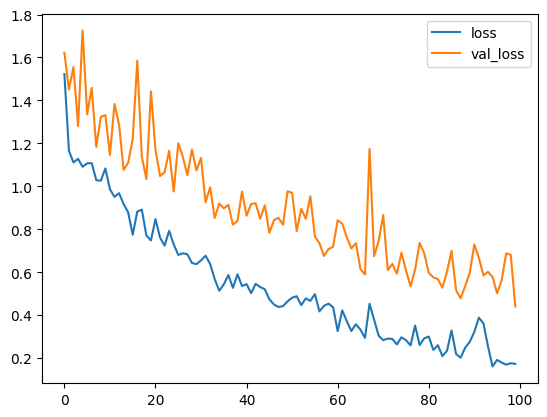

In [50]:
# comparing the training and validation loss.
metrics_df[["loss","val_loss"]].plot()

<Axes: >

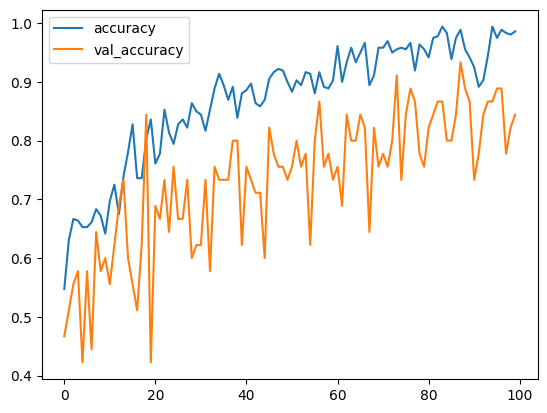

In [51]:
# comparing the training and validation accuracy.
metrics_df[["accuracy","val_accuracy"]].plot()

In [58]:
# For validation set
y_pred_val = np.argmax(hybrid_model2.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model2.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [59]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.8444444444444444
Test Accuracy: 0.9777777777777777
Validation Precision: 0.917283950617284
Test Precision: 0.9814814814814816
Validation Recall: 0.8444444444444444
Test Recall: 0.9777777777777777
Validation F1-score: 0.8506748806748806
Test F1-score: 0.9765656565656565


In [55]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

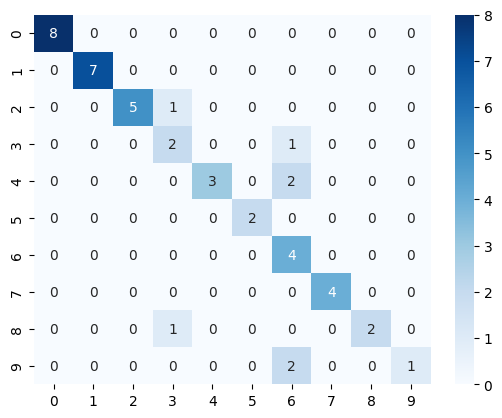

In [56]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

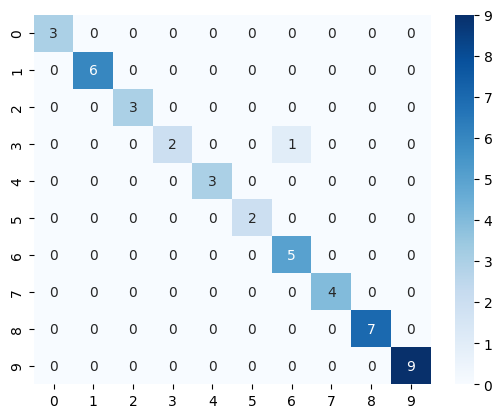

In [57]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

In [58]:
# MODEL (10C_3)
metrics_df = pd.DataFrame(history.history)

In [64]:
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.405830,0.100000,2.450448,0.066667
1,2.341935,0.108333,2.313233,0.066667
2,2.274890,0.122222,2.260836,0.177778
3,2.222161,0.172222,2.239219,0.200000
4,2.206687,0.200000,2.285830,0.088889


<Axes: >

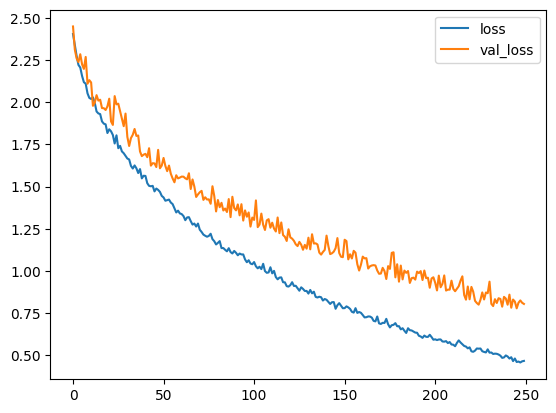

In [59]:
metrics_df[["loss","val_loss"]].plot()

<Axes: >

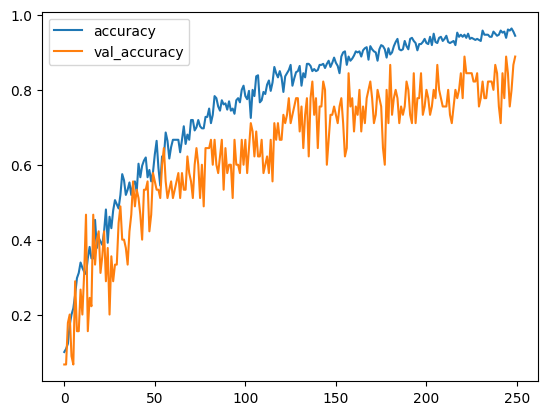

In [60]:
metrics_df[["accuracy","val_accuracy"]].plot()

In [ ]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

In [61]:
y_pred_val = np.argmax(hybrid_model2.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model2.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [62]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.8888888888888888
Test Accuracy: 0.8888888888888888
Validation Precision: 0.9214814814814816
Test Precision: 0.9344444444444444
Validation Recall: 0.8888888888888888
Test Recall: 0.8888888888888888
Validation F1-score: 0.8886195286195285
Test F1-score: 0.8962518454675318


In [66]:
train_dir = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\training_val_Res50_10C_3.csv'
# metrics_df.to_csv(log_dir)
metrics_df.to_csv(train_dir, index=False)

### ResNet50 + BiLSTM

In [94]:
# For validation set
y_pred_val = np.argmax(hybrid_model2.predict(X_val1, batch_size = 2), axis=-1)
y_val_t = np.argmax(y_val1, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model2.predict(X_test1, batch_size = 2), axis=-1)
y_test_t = np.argmax(y_test1, axis=-1)

In [97]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.8666666666666667
Test Accuracy: 0.9111111111111111
Validation Precision: 0.9022222222222223
Test Precision: 0.9435185185185184
Validation Recall: 0.8666666666666667
Test Recall: 0.9111111111111111
Validation F1-score: 0.872358505691839
Test F1-score: 0.9145441595441597


In [96]:
metrics_df1 = pd.DataFrame(history2_1.history)

<Axes: >

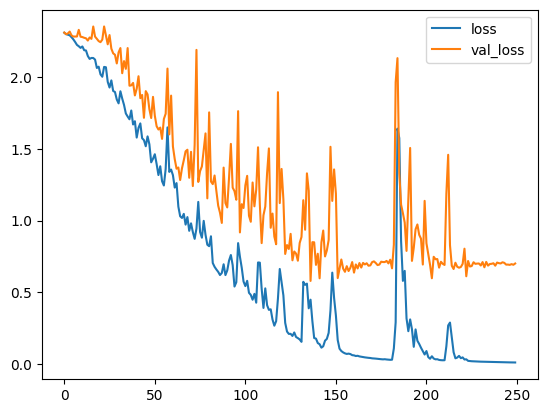

In [98]:
metrics_df1[["loss","val_loss"]].plot()

<Axes: >

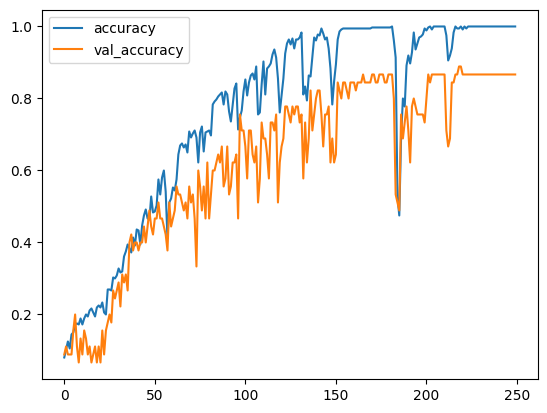

In [99]:
metrics_df1[["accuracy","val_accuracy"]].plot()

In [102]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

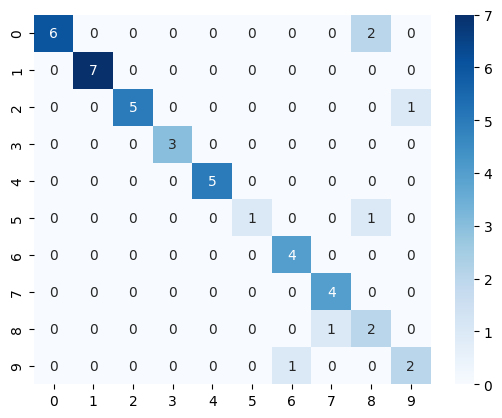

In [103]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

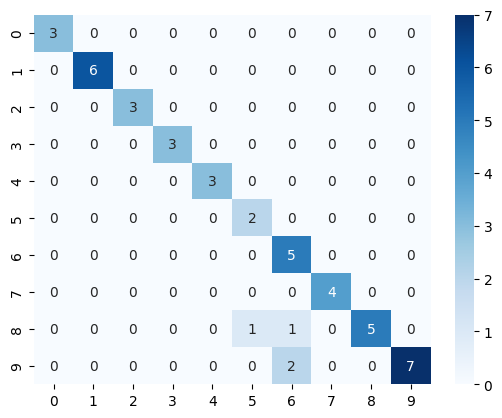

In [104]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

### Xception + BiLSTM

In [77]:
# For validation set
y_pred_val = np.argmax(hybrid_model.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [78]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.9333333333333333
Test Accuracy: 0.9111111111111111
Validation Precision: 0.9361111111111111
Test Precision: 0.912037037037037
Validation Recall: 0.9333333333333333
Test Recall: 0.9111111111111111
Validation F1-score: 0.9318518518518519
Test F1-score: 0.9038966697790226


In [71]:
metrics_df = pd.DataFrame(history.history)

<Axes: >

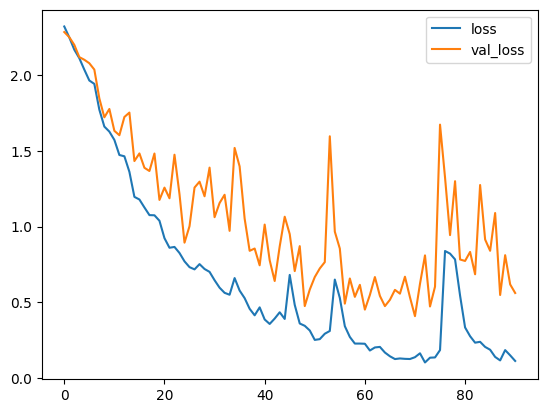

In [72]:
metrics_df[["loss","val_loss"]].plot()

<Axes: >

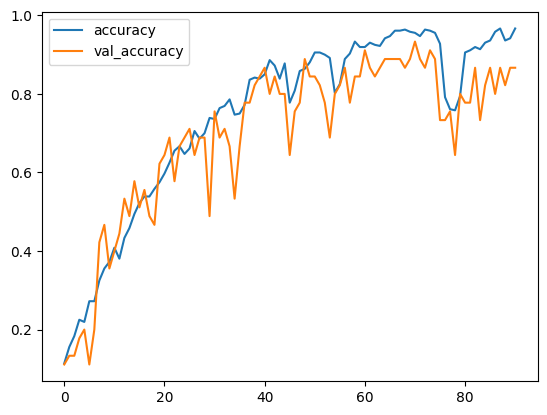

In [73]:
metrics_df[["accuracy","val_accuracy"]].plot()

In [79]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

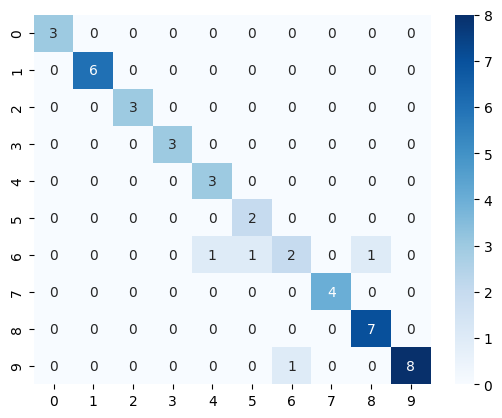

In [80]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

<Axes: >

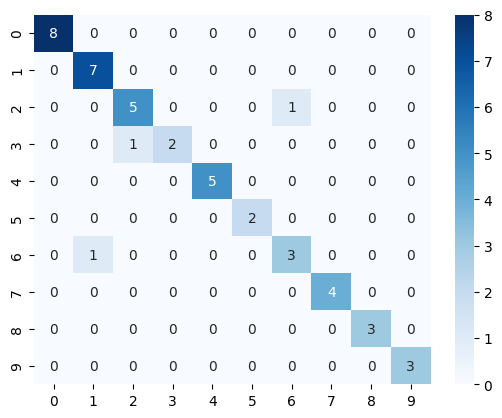

In [81]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

### Xception (Alone)

In [41]:
# Epoch results
epoch_results = {
    "Epoch": list(range(1, 15)),  # Assuming you have 16 epochs
    "loss": [4.8294, 0.4135, 0.1524, 0.1016, 0.0243, 0.0151, 0.0060, 0.0020, 0.0016, 0.0014, 0.0011, 0.0013, 0.0011, 0.0012],
    "accuracy": [0.3222, 0.8639, 0.9556, 0.9639, 0.9944, 1.0000, 0.9972, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
    "val_loss": [2.1333, 0.6744, 0.8309, 0.2593, 0.2109, 0.1541, 0.1255, 0.1206, 0.1234, 0.1006, 0.1056, 0.1021, 0.1033, 0.1025],
    "val_accuracy": [0.6000, 0.8667, 0.7556, 0.8889, 0.9556, 0.9111, 0.9333, 0.9556, 0.9333, 0.9556, 0.9556, 0.9556, 0.9778, 0.9556]
}


# Convert to DataFrame
metrics_df = pd.DataFrame(epoch_results)

In [38]:
# For validation set
y_pred_val = np.argmax(hybrid_model1.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model1.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [39]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.9777777777777777
Test Accuracy: 0.9555555555555556
Validation Precision: 0.9814814814814816
Test Precision: 0.9620370370370371
Validation Recall: 0.9777777777777777
Test Recall: 0.9555555555555556
Validation F1-score: 0.9779331779331779
Test F1-score: 0.9545286195286196


In [43]:
metrics_df = pd.DataFrame(history.history)

<Axes: >

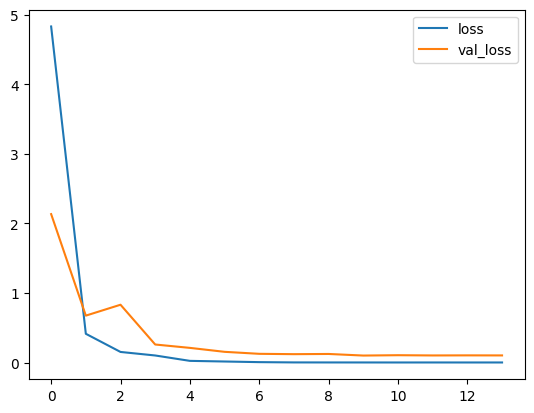

In [44]:
metrics_df[["loss","val_loss"]].plot()

<Axes: >

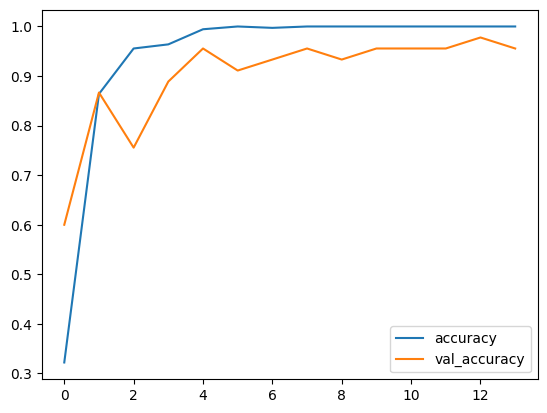

In [45]:
metrics_df[["accuracy","val_accuracy"]].plot()

In [46]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

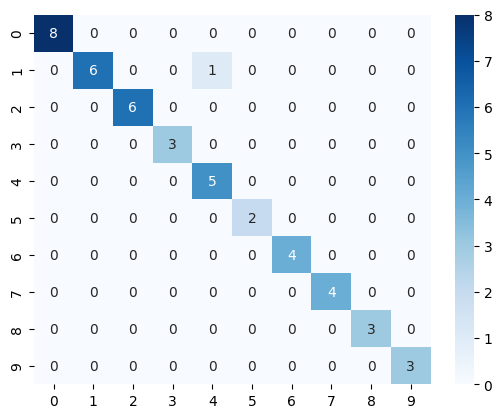

In [47]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

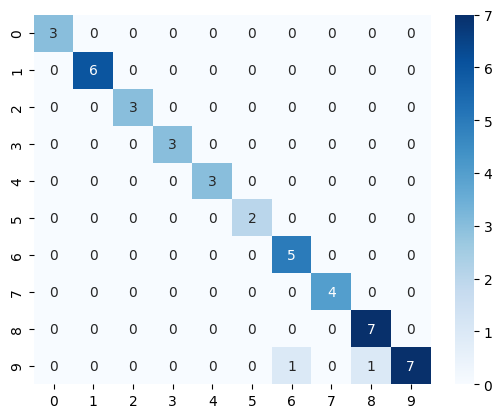

In [48]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

## Model Evaluation

#### Xception (alone)

In [44]:
# Resnet 50 model Alone
test_loss, test_accuracy = hybrid_model1.evaluate(x_t, y_t, batch_size = 2)

18/18 [==============================] - 2s 109ms/step - loss: 0.2711 - accuracy: 0.9167


In [45]:
print('Accuracy on test dataset:', test_accuracy)
print('Loss on test dataset:', test_loss)

Accuracy on test dataset: 0.9166666865348816
Loss on test dataset: 0.2710539698600769


In [178]:
# ResNet50 + BiLSTM
test_loss, test_accuracy = hybrid_model2_2.evaluate(x_t, y_t, batch_size = 2)
print('Accuracy on test dataset:', test_accuracy)
print('Loss on test dataset:', test_loss)

18/18 [==============================] - 1s 12ms/step - loss: 0.6206 - accuracy: 0.9444
Accuracy on test dataset: 0.9444444179534912
Loss on test dataset: 0.620599091053009


In [177]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x_t = tf.convert_to_tensor(X_test, np.float32)
   y_t = tf.convert_to_tensor(y_test, np.float32)


In [43]:
X_test.shape

(36, 20, 224, 224, 3)